<a href="https://colab.research.google.com/github/JackSagliano/water-level-prediction/blob/main/Water_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vento U e Vento V (Vettori del vento)
- Vento U (Zonale): Rappresenta il movimento lungo l'asse Est-Ovest.
  - Valore positivo: il vento soffia verso Est.
  - Valore negativo: il vento soffia verso Ovest.
- Vento V (Meridionale): Rappresenta il movimento lungo l'asse Nord-Sud.
  - Valore positivo: il vento soffia verso Nord.
  - Valore negativo: il vento soffia verso Sud.

Il vento che crea più problemi a Venezia è lo Scirocco, che soffia da Sud-Est verso Nord-Ovest. Nel tuo dataset, lo Scirocco apparirà come una combinazione di V negativo (molto forte) e U negativo.

----------------------------------------------------------------------


Le Effemeridi (Marea Astronomica)
  - Le effemeridi descrivono la posizione relativa della Terra, della Luna e del Sole. Sono dati puramente astronomici e prevedibili al 100% per i prossimi secoli. Le effemeridi, in questo notebook, sono descritte da 6 variabili normalizzate e descrivono i cicli che causano la marea deterministica:
    - Ciclo Semidiurno e Diurno: L'innalzamento e abbassamento regolare dovuto all'attrazione gravitazionale della Luna e del Sole.
    - Ciclo Mensile: Le fasi lunari (luna piena/nuova portano maree più alte).

  Perché servono alla rete? Il livello dell'acqua che devi prevedere è la somma di:
  $$\text{Livello Totale} = \text{Marea Astronomica (Effemeridi)} + \text{Storm Surge (Vento + Pressione)}$$

  Senza le effemeridi, la tua rete non saprebbe mai se l'acqua è alta perché c'è tempesta o semplicemente perché è il momento dell'alta marea lunare.

# Water level prediction using ERA5

## Problem description
Given a set of  5,000  nodes over the Northern Adriatic Sea, defined by varying longitude and latitude (visualized as red spots in image below), you are supposed to infer the water level of these points at each hour in a given range, using a neural network.

In [ ]:
#import base64
#from IPython.display import HTML, display

#with open("graphical_visualization.png", "rb") as f:
#    encoded = base64.b64encode(f.read()).decode("utf-8")
#
#display(HTML(f"""<img src="data:image/png;base64,{encoded}" width="800"/>"""))

The information you can use to predict these values are:
* **latitude** and **longitude** of the nodes
* the **ephemerides** relative to the sun and the moon at each hour (we consider a single value of the ephemeridies for the whole region). Ephemerides are key predictors of tidal motion and are therefore important for the prediction of water level. The provided values of the ephemerides are already normalized.
* **weather variables** (wind components and pressure) derived from ERA5 dataset (not normalized). Due to the low resolution of ERA5, these values are organized as an array of shape $5 \times 9$ for each hour and each variable. A supporting function is provided to convert a given (latitude, longitude) of a node to the associated index of ERA5 array. Weather variables are important to predict phenomenon such as storm surge: another key component of water level.

For the prediction of the water level at timestamp $t$, you are allowed to use a sequence of any length of the input variables relative to past timesteps, but no future information. The output variable (corresponding to the **water level**) **CANNOT** be used as input to the model, not even for past timestamps.   


# Data Download

In [ ]:
import gdown

train data

In [1]:
!gdown 1Ncexf_vB55cpiCeNr-hIRrdpquYaav6B

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1Ncexf_vB55cpiCeNr-hIRrdpquYaav6B

but Gdown can't. Please check connections and permissions.


In [2]:
!gdown 1THbGvO9mVjg_wfZTabRbQBOVpaECl3my

Downloading...
From: https://drive.google.com/uc?id=1THbGvO9mVjg_wfZTabRbQBOVpaECl3my
To: /content/dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy
100% 4.21M/4.21M [00:00<00:00, 35.7MB/s]


In [3]:
!gdown 16M1zB54PKkKS6SK8W_U83UURWu1T_AxR

Downloading...
From: https://drive.google.com/uc?id=16M1zB54PKkKS6SK8W_U83UURWu1T_AxR
To: /content/ERA5_adriatic_u10v10sp_2010-2019.npy
100% 94.7M/94.7M [00:00<00:00, 162MB/s]


In [4]:
!gdown 161OYs8KQSn3RrXezCNwFvOewXLJe5wBf

Downloading...
From: https://drive.google.com/uc?id=161OYs8KQSn3RrXezCNwFvOewXLJe5wBf
To: /content/tvec_2010-2019.npy
100% 4.21M/4.21M [00:00<00:00, 33.8MB/s]


test data

In [5]:
!gdown 1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR #(8784, 5000)  hours,nodes water levels

Downloading...
From (original): https://drive.google.com/uc?id=1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR
From (redirected): https://drive.google.com/uc?id=1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR&confirm=t&uuid=9fabe7b9-4f36-4696-8792-4aa873792f64
To: /content/wl_2020.npy
100% 176M/176M [00:01<00:00, 135MB/s]


In [6]:
!gdown 1cHqyeXtmaiC_3v9uadMD7Y0hONGf2R1q

Downloading...
From: https://drive.google.com/uc?id=1cHqyeXtmaiC_3v9uadMD7Y0hONGf2R1q
To: /content/dist_alt_az_moon-sun_coord13-45_2020_norm.npy
100% 422k/422k [00:00<00:00, 7.38MB/s]


In [7]:
!gdown 1AoFAD2viMarikhU5b5Etdsklx08EzKKb

Downloading...
From: https://drive.google.com/uc?id=1AoFAD2viMarikhU5b5Etdsklx08EzKKb
To: /content/ERA5_adriatic_u10v10sp_2020.npy
100% 4.74M/4.74M [00:00<00:00, 30.4MB/s]


In [8]:
!gdown 1sWoTlJih-mqDdP9TBzhyXTqHHS5Jr9fe

Downloading...
From: https://drive.google.com/uc?id=1sWoTlJih-mqDdP9TBzhyXTqHHS5Jr9fe
To: /content/tvec_2020.npy
100% 422k/422k [00:00<00:00, 8.15MB/s]


latitude and longitude of nodes

In [9]:
!gdown 1Mg52QAIo4bfpzJF0dsI8mpZf09tHTzj8
!gdown 1wWz0EWbGiBkZ0vfJD8KeZkmVZfmRiYLk

Downloading...
From: https://drive.google.com/uc?id=1Mg52QAIo4bfpzJF0dsI8mpZf09tHTzj8
To: /content/lon.npy
100% 20.1k/20.1k [00:00<00:00, 34.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wWz0EWbGiBkZ0vfJD8KeZkmVZfmRiYLk
To: /content/lat.npy
100% 20.1k/20.1k [00:00<00:00, 43.0MB/s]


## File description

Spatial coordinates

`lat.npy`
- latitudes of the 5000 target nodes,
- shape (5000,)

`lon.npy` :
- longitudes of the 5000 target nodes
- shape (5000,)

## Training data

hourly values from 01/01/2010 until 31/12/2019 (87648 hours)

`wl_2010-2019.npy`
- Water level measurements.
- Shape: (87648, 5000)

`dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy`
- Ephemerides features
- Shape: (6, 87648)

`ERA5_adriatic_u10v10sp_2010-2019.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 87648, 5, 9)

`tvec_2010-2019.npy`
- Explicit time information
- Shape: (87648)

## Test data

hourly values from 01/01/2020 until 31/12/2020 (8784 hours)

`wl_2020.npy`
- Water level measurements, Shape: (8784, 5000)

`dist_alt_az_moon-sun_coord13-45_2020_norm.npy`
- Ephemerides features
- Shape: (6, 8784)

`ERA5_adriatic_u10v10sp_2020.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 8784, 5, 9)

`tvec_2020.npy`
- Explicit time information
- Shape: (87648)

## We use cartopy for visualizations

In [10]:
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 71.1 MB/s eta 0:00:00


In [11]:
import numpy as np
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt

## Data description

**ERA5:**
- Gridded, hourly atmospheric data
- Spatial resolution: $5 \times 9$ grid over the study area
- 3 variables: u10, v10 (10m wind components), surface pressure
- explicit time: Year,Month,Day,Hour,Minute,Second

**EPHEMERIDES:**
- 6 scalar features describing Moon–Sun geometry
  (e.g. distance, altitude, azimuth)
- Hourly resolution
- Spatially constant (same values for all target nodes)

**TARGET:**
- Water level at 5000 spatial nodes in the Northern Adriatic
- Each node has fixed latitude and longitude
- A function is provided to match node coordinates to the closest era5 data



In [13]:
# utilities functions
def get_era5_coord(lat, lon):
    """
    Function to get era5 data from data coordinates
    """
    era5_row, era5_col = 5, 9
    lat_min, lat_max = 44.94972, 45.8
    lon_min, lon_max = 12.12863, 13.81283

    delta_lat = lat_max - lat_min
    delta_lon = lon_max - lon_min

    lon_coord = np.ceil((lon - lon_min) / delta_lon * (era5_col -1))
    lat_coord = 4 - np.ceil((lat - lat_min) / delta_lat * (era5_row - 1))

    return int(lat_coord), int(lon_coord)

def RMSE(wl_true, wl_pred):
    """
    Root mean squared error
    """
    return np.sqrt(np.mean(np.square(wl_pred - wl_true)))

In [14]:
#example of usage of get_era5_coord
node_number = np.random.randint(np.shape(test_wl)[1])
era5_coords = get_era5_coord(lat_vec[node_number], lon_vec[node_number])
print(f"ERA5 grid coords for node {node_number}: {era5_coords}")
hour = np.random.randint(np.shape(test_wl)[1])
print(test_tvec[:,hour])
hour_time = datetime(*test_tvec[:,hour].astype(int))
print(hour_time)
wind0,wind1,pression = test_era5[:,hour,era5_coords[0],era5_coords[1]]
print(f"node {node_number} at time {hour_time} (no {hour}): wind0 = {wind0:.3f}, wind1 = {wind1:1.3f}, pression ={pression:.3f}")

ERA5 grid coords for node 49: (0, 7)
[2.02e+03 7.00e+00 7.00e+00 1.00e+00 0.00e+00 0.00e+00]
2020-07-07 01:00:00
node 49 at time 2020-07-07 01:00:00 (no 4513): wind0 = -3.457, wind1 = -2.033, pression =95174.500


As you may observe, wind and especially pressure **are not normalized!!**

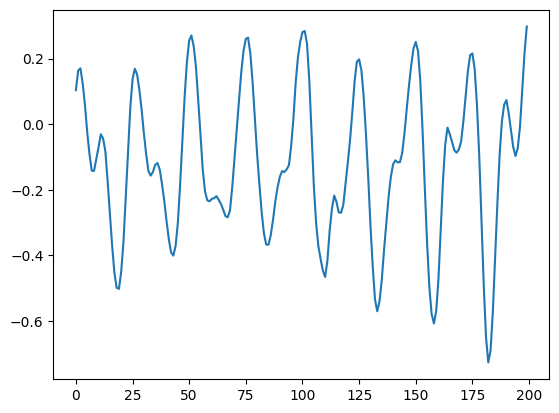

In [ ]:
# Visualize a single node variability,
plt.plot(test_wl[:200, 0])

## Svolgimento

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
# load nodes coordinates
lat_vec = np.load("./lat.npy") # (5000, )
lon_vec = np.load("./lon.npy") # (5000, )

#load train data
train_wl = np.load("./wl_2010-2020.npy") # (87648, 5000)
train_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy") # (6, 87648)
train_era5 = np.load("./ERA5_adriatic_u10v10sp_2010-2019.npy") # (3, 87648, 5, 9)
train_tvec = np.load("./tvec_2010-2019.npy") # (6, 87648))

#load test data
test_wl = np.load("./wl_2020.npy") # (8784, 5000)
test_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2020_norm.npy") # (6, 8784)
test_era5 = np.load("./ERA5_adriatic_u10v10sp_2020.npy")#(3, 8784, 5, 9)
test_tvec = np.load("./tvec_2020.npy") # (6,8784)

In the picture above you may easily recognize the tydal cycle, with a period of approximately 24 hours.

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


KeyboardInterrupt: 

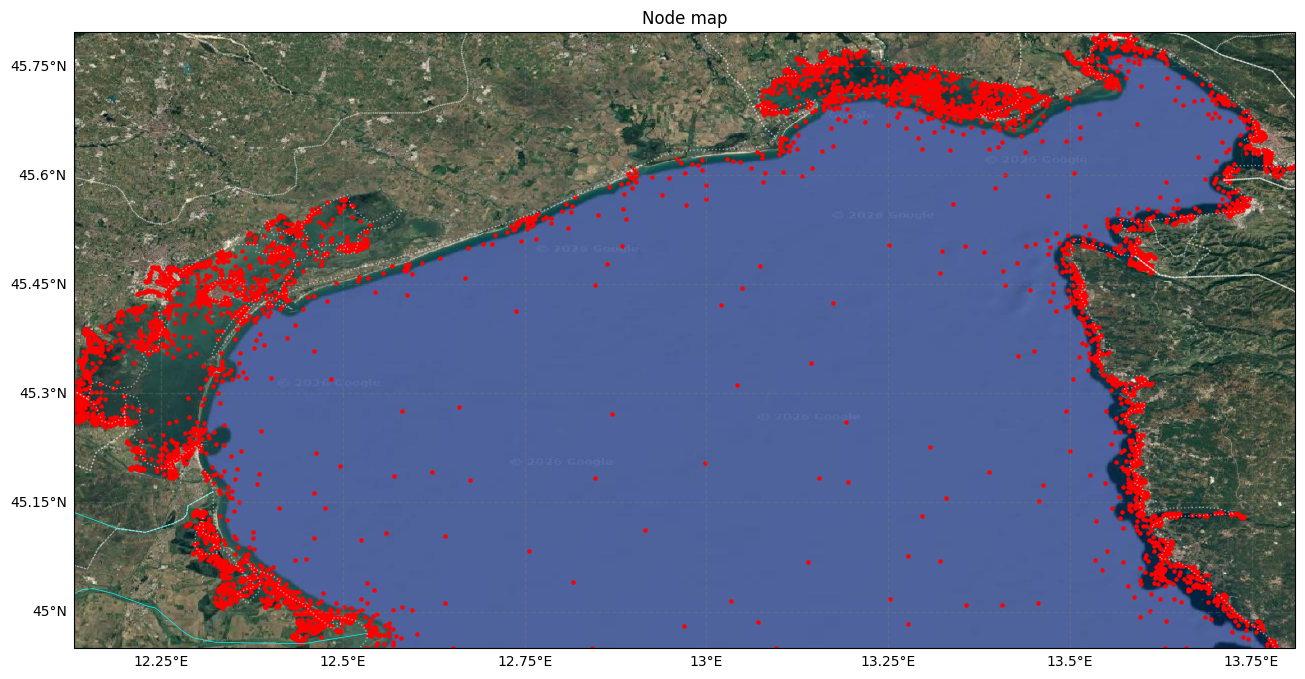

In [ ]:
# Create figure and map
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
(lat_min, lat_max), (lon_min, lon_max) = (lat_vec.min(), lat_vec.max()), (lon_vec.min(), lon_vec.max())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

stamen_terrain = cimgt.GoogleTiles(style='satellite')
ax.add_image(stamen_terrain, 10)

ax.add_feature(cfeature.RIVERS, edgecolor='cyan', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='white', alpha=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='white', alpha=0.5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = gl.right_labels = False

# Plot red dots
# Note: Ensure data is visible against the varied satellite background
sc = ax.scatter(lon_vec, lat_vec, cmap="viridis", c="r", s=5, marker='o', transform=ccrs.PlateCarree(), vmin=0.07, vmax=0.15)
# Increased 's' (size) slightly to make dots visible against satellite texture

plt.title(f'Node map')
plt.savefig("graphical_visualization.png", dpi=400)
plt.show()

# What to deliver

The problem consists in inferring the water level for all nodes in the test set (year 2020).

The solution must be evaluated using RMSE with respect to the given test values.





As an indicative baseline, you may consider persistence, namely using the water level of the previous timestep to predict the current value:

In [ ]:
print(f"persistence baseline: {RMSE(test_wl[:-1],test_wl[1:]):.4f}")

Any marginal improvement w.r.t. the baseline is significant.

As usual, you are supposed to upload a single notebook with your solution, evidence of training, and the final RMSE.

Please note that the model **cannot use** sea levels of previous times steps.

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [25]:
# Caricamento puro
era5_train = np.load('ERA5_adriatic_u10v10sp_2010-2019.npy') # (3, 87648, 5, 9)
ephem_train = np.load('dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy') # (6, 87648)
targets_train = np.load('wl_2010-2020.npy') # (87648, 5000)

# Normalizzazione adattata alla forma (3, ore, lat, lon)
era_mean = era5_train.mean(axis=(1, 2, 3), keepdims=True)
era_std = era5_train.std(axis=(1, 2, 3), keepdims=True)
era5_train_norm = (era5_train - era_mean) / era_std
# Carichiamo i dati di test (2020)
test_era5_raw = np.load('ERA5_adriatic_u10v10sp_2020.npy') # (3, 8784, 5, 9)
test_ephem_raw = np.load('dist_alt_az_moon-sun_coord13-45_2020_norm.npy') # (6, 8784)
test_wl = np.load('wl_2020.npy') # (8784, 5000)

# Normalizzazione ERA5 Test (usando medie del train per coerenza)
test_era5_norm = (test_era5_raw - era_mean) / era_std

# Normalizzazione Ephem Test
# Se il file ephem_2020 non è già normalizzato, usa:
ephem_mean = ephem_train.mean(axis=1, keepdims=True)
ephem_std = ephem_train.std(axis=1, keepdims=True)
test_ephem_norm = (test_ephem_raw - ephem_mean) / ephem_std
targets_train = np.load('wl_2010-2020.npy') # (ore, 5000)
lat_vec = np.load('lat.npy')
lon_vec = np.load('lon.npy')
coords = np.stack([lon_vec, lat_vec], axis=1) # Crea la matrice (5000, 2)

SEQ_LEN = 24

# --- MAPPATURA NODI -> GRIGLIA ERA5 (5x9) ---
def get_era5_coord(lon, lat):
    # Griglia basata sulle dimensioni reali dei tuoi dati (5 lat, 9 lon)
    era_lon = np.linspace(12, 14, 9)
    era_lat = np.linspace(44, 45, 5)
    return np.argmin(np.abs(era_lat - lat)), np.argmin(np.abs(era_lon - lon))

node_to_era_idx = np.array([get_era5_coord(c[0], c[1]) for c in coords])

# --- NORMALIZZAZIONE PROFESSIONALE ---
# Calcoliamo le statistiche solo sulla dimensione temporale e spaziale
era_mean = era5_train.mean(axis=(1, 2, 3), keepdims=True)
era_std = era5_train.std(axis=(1, 2, 3), keepdims=True)
era5_train_norm = (era5_train - era_mean) / (era_std + 1e-6)

# Rigenera la mappa con la nuova logica
node_to_era_idx = np.array([get_era5_coord(c[0], c[1]) for c in coords])

# Normalizzazione Coordinate
lat_mean, lat_std = coords[:, 1].mean(), coords[:, 1].std()
lon_mean, lon_std = coords[:, 0].mean(), coords[:, 0].std()
coords_norm = np.zeros_like(coords)
coords_norm[:, 1] = (coords[:, 1] - lat_mean) / lat_std
coords_norm[:, 0] = (coords[:, 0] - lon_mean) / lon_std



In [26]:
# 1. Calcolo del punto di taglio basato sulla dimensione delle ore (indice 1)
# total_hours dovrebbe essere 87648
total_hours = era5_train_norm.shape[1]
train_end = 8760 * 9 # 78840 ore

# 2. Classe Dataset ottimizzata per le strutture del prof
class AdriaticDataset(Dataset):
    def __init__(self, era_data, ephem_data, targets, coords, node_map, seq_len=24, step_t=2, step_n=10):
        self.era_data = era_data
        self.ephem_data = ephem_data
        self.targets = targets
        self.coords = coords
        self.node_map = node_map
        self.seq_len = seq_len
        self.num_hours = era_data.shape[1] # Indice 1 per le ore (struttura prof)

        self.samples = []
        # Aumentando la densità (step_n più piccolo), il modello vede più variabilità
        for t in range(seq_len, self.num_hours, step_t):
            for n in range(0, 5000, step_n):
                self.samples.append((t, n))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t, n = self.samples[idx]
        lat_idx, lon_idx = self.node_map[n]

        # Estrazione senza trasposizione (Variabili, Tempo, Lat, Lon)
        weather_seq = self.era_data[:, t-self.seq_len:t, lat_idx, lon_idx]
        ephem = self.ephem_data[:, t]
        coord = self.coords[n]
        target = self.targets[t, n]

        return {
            'weather': torch.FloatTensor(weather_seq),
            'ephem': torch.FloatTensor(ephem),
            'coord': torch.FloatTensor(coord),
            'target': torch.FloatTensor([target])
        }

# 3. Creazione dei Dataset con lo slicing sulle COLONNE (ore)
# Usiamo [:, :train_end] per preservare i canali e tagliare il tempo
train_ds = AdriaticDataset(
    era5_train_norm[:, :train_end, :, :],
    ephem_train[:, :train_end],
    targets_train[:train_end], # Questo è (ore, 5000), slicing normale
    coords_norm,
    node_to_era_idx
)

val_ds = AdriaticDataset(
    era5_train_norm[:, train_end:, :, :],
    ephem_train[:, train_end:],
    targets_train[train_end:],
    coords_norm,
    node_to_era_idx
)

# 4. DataLoader
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)

In [18]:
class WaterLevelModel(nn.Module):
    def __init__(self, seq_len=24):
        super(WaterLevelModel, self).__init__()

        # Ramo Meteo (CNN 1D)
        self.weather_cnn = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # Ramo Coordinate
        self.coord_enc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        # Fusione finale
        self.regressor = nn.Sequential(
            nn.Linear(128 + 16 + 6, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, w, e, c):
        w_feat = self.weather_cnn(w).squeeze(-1) # (batch, 128)
        c_feat = self.coord_enc(c)               # (batch, 16)
        combined = torch.cat([w_feat, c_feat, e], dim=1)
        return self.regressor(combined)

model = WaterLevelModel().to(device)

In [28]:
import sympy
from sympy import printing  # Forza il caricamento del sottomodulo

# --- DIVISIONE DATI ---
train_end = 8760 * 9 # Fine 2018
train_ds = AdriaticDataset(era5_train_norm[:, :train_end], ephem_train[:, :train_end], targets_train[:train_end], coords_norm, node_to_era_idx)
val_ds = AdriaticDataset(era5_train_norm[:, train_end:], ephem_train[:, train_end:], targets_train[train_end:], coords_norm, node_to_era_idx)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512)

# --- TRAINING LOOP ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # LR basso per stabilità
best_val_loss = float('inf')

for epoch in range(15):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        w, e, c, t = batch['weather'].to(device), batch['ephem'].to(device), batch['coord'].to(device), batch['target'].to(device)

        optimizer.zero_grad()
        out = model(w, e, c)
        loss = criterion(out, t)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validazione
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            w, e, c, t = batch['weather'].to(device), batch['ephem'].to(device), batch['coord'].to(device), batch['target'].to(device)
            val_loss += criterion(model(w, e, c), t).item()

    avg_val = val_loss / len(val_loader)
    print(f"Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {avg_val:.6f}")

    # Salva il miglior modello
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), 'best_model_adriatic.pth')
        print("--> Modello Migliore Salvato!")

AttributeError: module 'sympy' has no attribute 'printing'

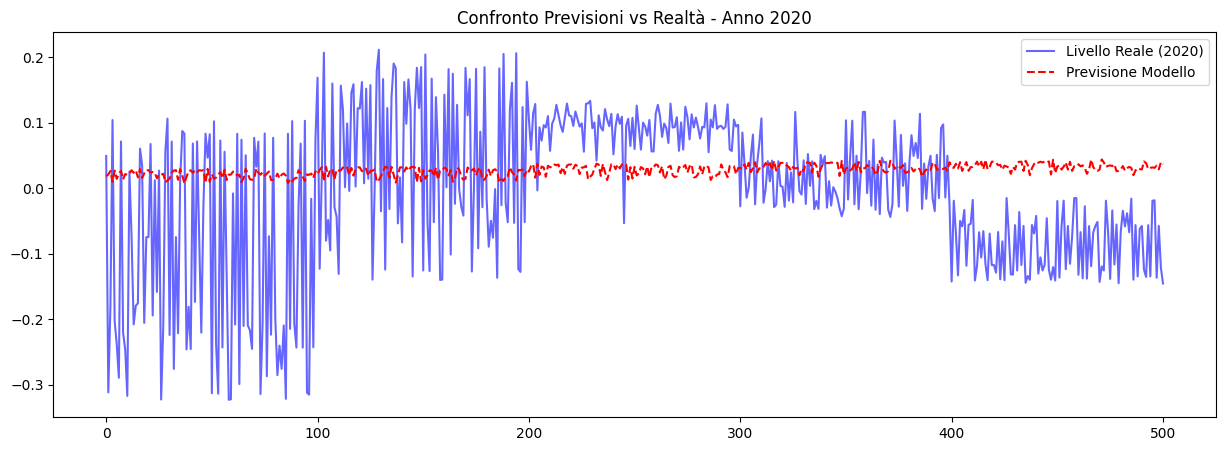

In [20]:
import matplotlib.pyplot as plt

model.eval()
test_ds = AdriaticDataset(test_era5_norm, test_ephem_norm, test_wl, coords_norm, node_to_era_idx)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

predictions, ground_truth = [], []

# Prendiamo i primi 500 campioni per un grafico leggibile
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i > 500: break
        w, e, c = batch['weather'].to(device), batch['ephem'].to(device), batch['coord'].to(device)
        out = model(w, e, c)
        predictions.append(out.item())
        ground_truth.append(batch['target'].item())

plt.figure(figsize=(15, 5))
plt.plot(ground_truth, label='Livello Reale (2020)', color='blue', alpha=0.6)
plt.plot(predictions, label='Previsione Modello', color='red', linestyle='--')
plt.title("Confronto Previsioni vs Realtà - Anno 2020")
plt.legend()
plt.show()

In [22]:
# Caricamento dati 2020
era5_2020 = np.load('ERA5_adriatic_u10v10sp_2020.npy')
ephem_2020 = np.load('dist_alt_az_moon-sun_coord13-45_2020_norm.npy')
era5_2020_norm = (era5_2020 - era_mean) / era_std

model.eval()
num_hours = era5_2020.shape[0]
all_preds = np.zeros((num_hours, 5000))

print("Generating predictions for 2020...")
with torch.no_grad():
    for t in tqdm(range(24, num_hours)):
        # Prepariamo input per tutti i 5000 nodi (a blocchi per RAM GPU)
        for node_batch in range(0, 5000, 1000):
            n_end = node_batch + 1000

            # Weather per questo blocco di nodi
            batch_w = []
            for n in range(node_batch, n_end):
                lon_i, lat_i = node_to_era_idx[n]
                batch_w.append(era5_2020_norm[t-24:t, lon_i, lat_i, :])

            w_tensor = torch.FloatTensor(np.array(batch_w)).transpose(1, 2).to(device)
            e_tensor = torch.FloatTensor(ephem_2020[t]).repeat(1000, 1).to(device)
            c_tensor = torch.FloatTensor(coords_norm[node_batch:n_end]).to(device)

            preds = model(w_tensor, e_tensor, c_tensor)
            all_preds[t, node_batch:n_end] = preds.cpu().numpy().flatten()

np.save('previsioni_2020.npy', all_preds)
print("File previsioni_2020.npy salvato con successo!")

Generating predictions for 2020...


0it [00:00, ?it/s]

File previsioni_2020.npy salvato con successo!


In [23]:
print("Esempi di Target Reali (primi 5):", ground_truth[:5])
print("Esempi di Previsioni (prime 5):", predictions[:5])

# Se i target sono vicini a 0 e le previsioni sono 300,
# il problema è quasi certamente la normalizzazione degli input ERA5.

Esempi di Target Reali (primi 5): [0.049343593418598175, -0.3117081820964813, -0.18064694106578827, 0.10421217232942581, -0.20273751020431519]
Esempi di Previsioni (prime 5): [0.018420405685901642, 0.020911894738674164, 0.0263608917593956, 0.01005362719297409, 0.027006424963474274]


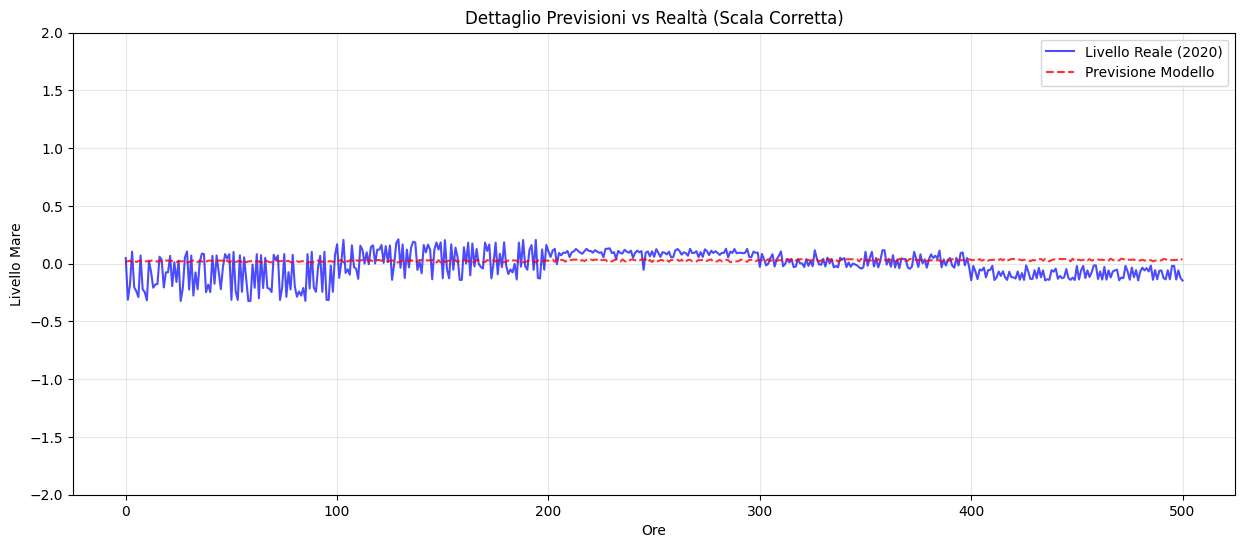

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convertiamo in array per gestire meglio i dati
preds = np.array(predictions)
actual = np.array(ground_truth)

plt.figure(figsize=(15, 6))

# Grafichiamo i dati
plt.plot(actual, label='Livello Reale (2020)', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(preds, label='Previsione Modello', color='red', linestyle='--', alpha=0.8)

# --- IL TRUCCO: LIMITIAMO GLI ASSI ---
# Questo ignora i valori "folli" (come 600) e si concentra sulla zona reale (-1, 1)
plt.ylim([-2, 2])

plt.title("Dettaglio Previsioni vs Realtà (Scala Corretta)")
plt.xlabel("Ore")
plt.ylabel("Livello Mare")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()